In [2]:
%matplotlib inline

In [3]:
import pandas as pd
from sklearn import linear_model, cross_validation
from sklearn import grid_search
import pylab as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
pd.set_option("precision", 2)
execfile("../toolbox.py")

## Importing the data

In [4]:
data = pd.read_csv("forbes_dataset.csv", index_col=['code', 'year'])
print "Number of countries : ", len(data.index.levels[0])
for var in data.keys():
    data[var] = growth(data, var, how='past')
data = data.dropna(how='any')
data.reset_index(inplace=True)
data = data.set_index(['code', 'year']).sort_index(level=[0, 1])
print data.info()

Number of countries :  46
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, (AUS, 1980.0) to (VEN, 1985.0)
Data columns (total 6 columns):
gini           135 non-null float64
PPPI           135 non-null float64
sch_male       135 non-null float64
sch_female     135 non-null float64
log(GNI_PC)    135 non-null float64
growth         135 non-null float64
dtypes: float64(6)
memory usage: 7.4+ KB
None


In [5]:
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:1063: FutureWarning: scalar indexers for index type Index should be integers and not floating point
  obj = self._convert_scalar_indexer(obj, axis)


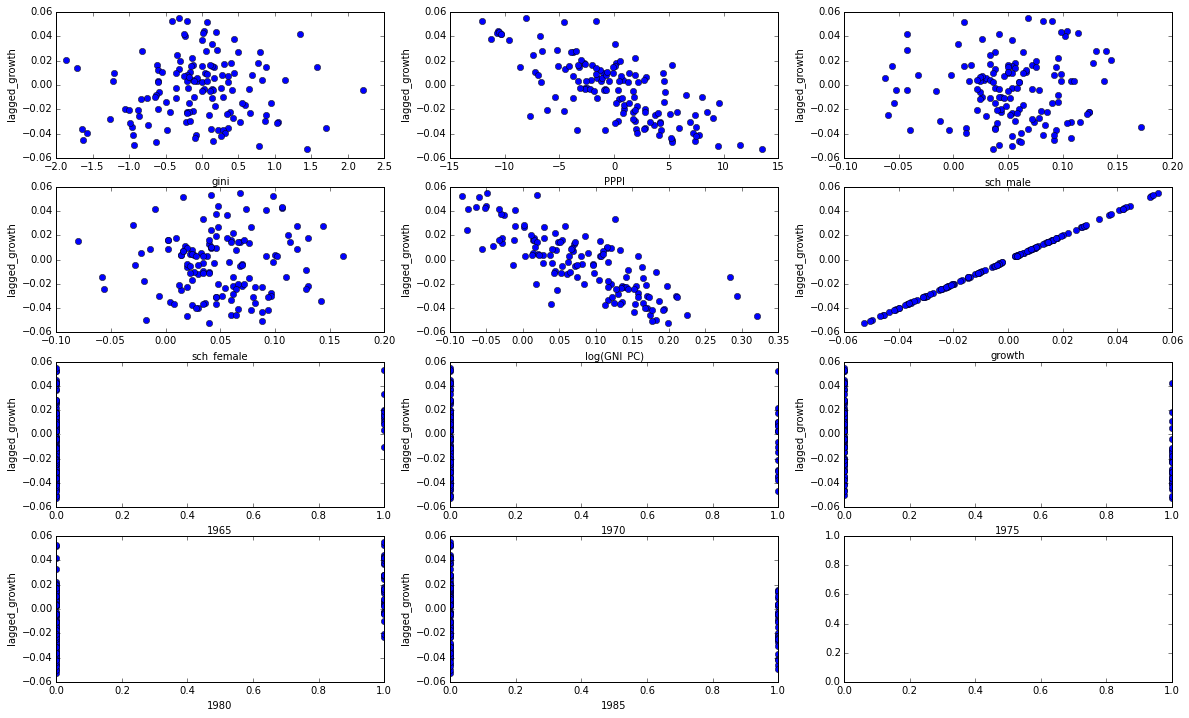

In [6]:
f, axarr = plt.subplots(4, 3, figsize=(20,12))
for n, var in enumerate(data.keys()):
    i,j = n/3, n%3
    axarr[i, j].plot(data[var], data['growth'], 'o')
    axarr[i, j].set_xlabel(var)
    axarr[i, j].set_ylabel('lagged_growth')

## Normalize the data

In [7]:
data = (data - data.mean(axis=0)) / data.std(axis=0)

## Define the variables

In [8]:
variables = data.keys().tolist()[:4] #+ ['log(GNI_PC)']
dummies = sorted(np.unique(data.index.levels[1]))

## Select the variables

In [9]:
X = data[variables + dummies]
Y = data['growth']

## Linear regression

Original variance of the sample :  1.0
Variance of the residu : 0.338590185409
Explained variance share :  0.661409814591
Gini coefficient :  0.0970874365066
estimation of the gini importance :  1.57712730864e-15
               0
gini        0.10
PPPI       -0.69
sch_male    0.03
sch_female  0.08
                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     30.82
Date:                Wed, 23 Mar 2016   Prob (F-statistic):           2.94e-26
Time:                        09:33:18   Log-Likelihood:                -117.87
No. Observations:                 135   AIC:                             253.7
Df Residuals:                     126   BIC:                             279.9
Df Model:                           8                                 

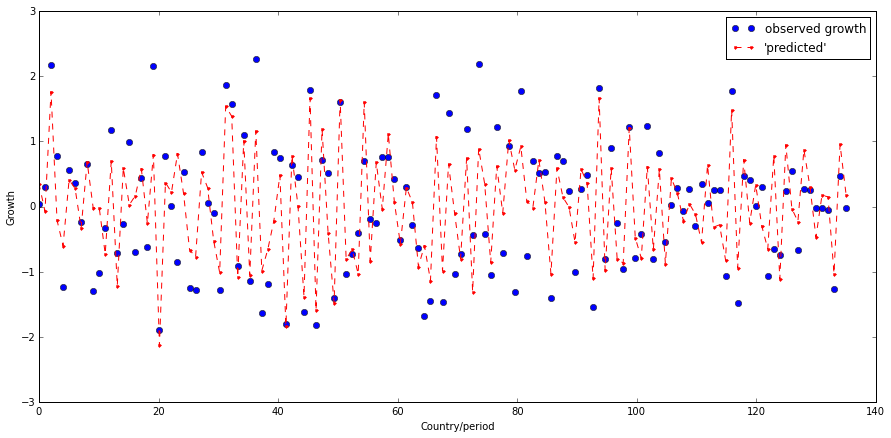

In [10]:
clf = linear_model.LinearRegression()
clf.fit(X, Y)

x = np.linspace(0, len(data), len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")
#plt.savefig("../notes/OLS_results.pdf", bbox_inches="tight")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X.keys(), data=clf.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", clf.coef_[0] / np.absolute(clf.coef_).sum()
print pd.DataFrame(index=X.columns, data=clf.coef_).loc[variables]

X_sm = sm.add_constant(X)
model = sm.OLS(Y, X_sm)
all_results = model.fit()
print(all_results.summary())

0.0372759372031


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


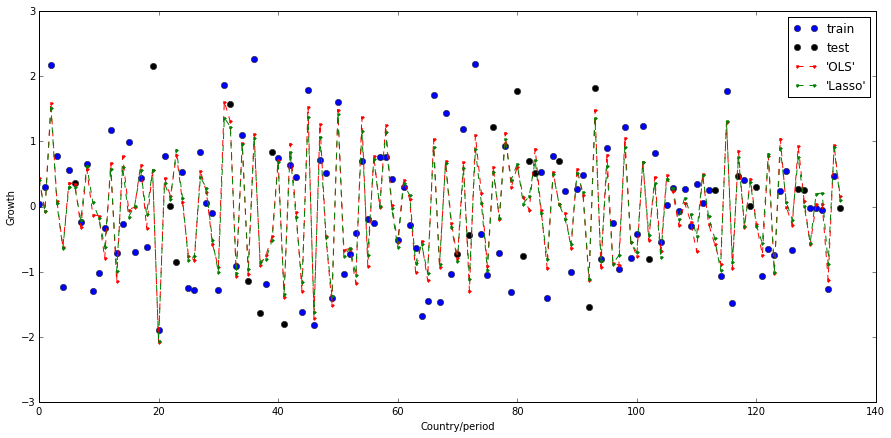

In [11]:
n_folds = 5

# Finding the best alpha
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf_lasso = grid_search.RandomizedSearchCV(lm, parameters, cv=n_folds)
clf_lasso.fit(X, Y)
best_alpha = clf_lasso.best_params_['alpha']


clf = linear_model.LinearRegression()
clf.fit(X, Y)

R_dict = {'lasso': [], 'OLS': []}
for var in X.keys():
    R_dict[var] = []
for k in range(20):
    kf = cross_validation.KFold(len(X), n_folds=n_folds, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        clf = linear_model.Lasso(alpha=10**-12)
        clf.fit(X_train, Y_train)
        clf_l = linear_model.Lasso(alpha=best_alpha)
        clf_l.fit(X_train, Y_train)
        #print i, "th fold"
        OLS_res = (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var()
        #print "R^2 OLS", OLS_res
        lasso_res = (Y_test.var() - (Y_test - clf_l.predict(X_test)).var()) / Y_test.var()
        #print "R^2 Lasso", lasso_res
        R_dict['lasso'].append(lasso_res)
        R_dict['OLS'].append(OLS_res)
        for i, var in enumerate(X.keys()):
            R_dict[var].append(clf_l.coef_[i])
        #print '\n'

print best_alpha
x = range(len(data))
plt.figure(figsize=(15,7))
plt.plot(train_index, Y_train, 'bo', label="train")
plt.plot(test_index, Y_test, 'ko', label="test")
plt.plot(x, clf.predict(X), 'r--.', label="'OLS'")
plt.plot(x, clf_l.predict(X), 'g--.', label="'Lasso'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")
# plt.savefig("../notes/OLS_Lasso.pdf")

In [12]:
print np.mean(R_dict['lasso']), np.std(R_dict['lasso'])
print np.mean(R_dict['OLS']), np.std(R_dict['OLS'])
res = pd.DataFrame(pd.DataFrame(R_dict).mean(), columns=['mean_coef'])
res['sort'] = res.mean_coef.apply(abs)
res.sort_values("sort", ascending=False)['mean_coef']

0.603114556921 0.103300964828
0.597397277788 0.117872741895


PPPI         -6.36e-01
lasso         6.03e-01
OLS           5.97e-01
1975         -2.24e-01
1965          1.43e-01
gini          4.21e-02
1985         -3.69e-02
sch_female    3.41e-02
1970          2.16e-02
sch_male      1.41e-02
1980          1.47e-03
Name: mean_coef, dtype: float64

## Same linear regression in two steps

In [ ]:
for var in variables:
    f, axarr = plt.subplots(1, 2, figsize=(15, 5))
    axarr[0].set_xlabel(var)    
    axarr[0].plot(data[var], Y, 'o')
    axarr[0].set_title('growth')
    axarr[1].set_xlabel(var)    
    axarr[1].plot(data[var], Y, 'o')
    axarr[1].set_title('stand_growth')

In [ ]:
for var in variables + ['growth']:
    print "Mean standard deviation of the " + var + " within a country : ", data[var].groupby(level=0).std().mean()
    print "Expected value", np.mean([np.random.choice(data[var], k).std() 
                                     for k in data[var].groupby(level=0).size().tolist() * 200])
    print '\n'

In [ ]:
high_school = data[data['sch_female'] > data['sch_female'].median()]
low_school = data[data['sch_female'] <= data['sch_female'].median()]
plt.figure(figsize=(10, 10))

model = linear_model.LinearRegression()
model.fit(data['gini'].reshape((len(data),1)), data['growth'].reshape((len(data),1)))

low_model = linear_model.LinearRegression()
low_model.fit(low_school['gini'].reshape((len(low_school),1)), low_school['growth'].reshape((len(low_school),1)))

high_model = linear_model.LinearRegression()
high_model.fit(high_school['gini'].reshape((len(high_school),1)), high_school['growth'].reshape((len(high_school),1)))

plt.plot(high_school['gini'], high_school['growth'], 'bo')
plt.plot(high_school['gini'], high_model.predict(high_school['gini'].reshape((len(high_school),1))), 'b-')

plt.plot(low_school['gini'], low_school['growth'], 'go')
plt.plot(low_school['gini'], low_model.predict(low_school['gini'].reshape((len(low_school),1))), 'g-')

plt.plot(data['gini'], model.predict(data['gini'].reshape((len(data),1))), 'r-')

# Cross validating the coefficient to ensure no overfitting

In [ ]:
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=18)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

In [ ]:
coefs = pd.DataFrame(index=X.keys(), data=clf.best_estimator_.coef_)
print coefs[coefs[0]!=0]

Faire un lasso en autorisant uniquement une pénalisation sur les dummies pays (en ajoutant éventuellement les pays les plus particuliers)

# Try to cross validate the sign of the gini coefficient

In [ ]:
coefs = pd.DataFrame(index=X.keys())
kf = cross_validation.KFold(len(X), n_folds=4, shuffle=True)
for i, (train_index, test_index) in enumerate(kf):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]
    clf = linear_model.LinearRegression()
    clf.fit(X_train, Y_train)
    print i, "th fold"
    print "Original variance of the sample : ", Y_test.var()
    print "Variance of the residu :", (Y_test - clf.predict(X_test)).var()
    print "Explained variance share : ", (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var(), '\n'
    coefs[i] = clf.coef_
coefs['std'] = coefs.std(axis=1)
coefs['mean'] = coefs.mean(axis=1)
print coefs

# Comparing the Lasso with the OLS

{'alpha': 0.00026826957952797272}

{'alpha': 0.00086851137375135298}


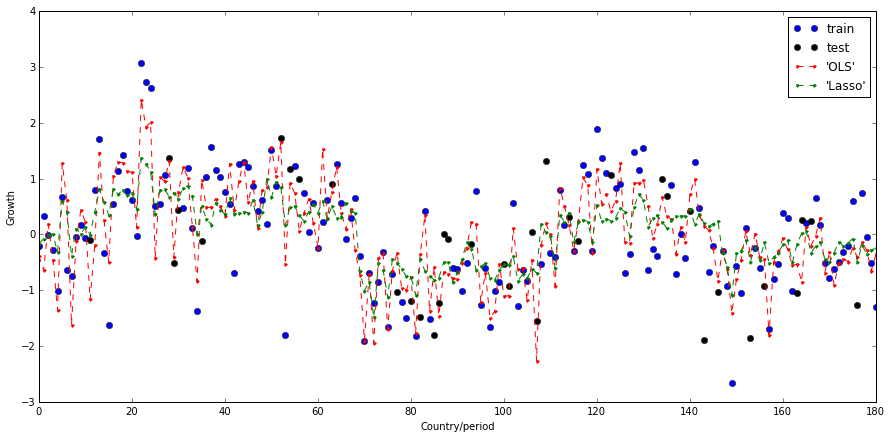

In [24]:
n_folds = 5

# Finding the best alpha
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf_lasso = grid_search.RandomizedSearchCV(lm, parameters, cv=n_folds)
clf_lasso.fit(X, Y)
best_alpha = clf_lasso.best_params_ 


clf = linear_model.LinearRegression()
clf.fit(X, Y)

R_dict = {'lasso': [], 'OLS': []}
for var in X.keys():
    R_dict[var] = []
for k in range(2000):
    kf = cross_validation.KFold(len(X), n_folds=n_folds, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        clf = linear_model.Lasso(alpha=10**-12)
        clf.fit(X_train, Y_train)
        clf_l = linear_model.Lasso(alpha=0.059)
        clf_l.fit(X_train, Y_train)
        #print i, "th fold"
        OLS_res = (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var()
        #print "R^2 OLS", OLS_res
        lasso_res = (Y_test.var() - (Y_test - clf_l.predict(X_test)).var()) / Y_test.var()
        #print "R^2 Lasso", lasso_res
        R_dict['lasso'].append(lasso_res)
        R_dict['OLS'].append(OLS_res)
        for i, var in enumerate(X.keys()):
            R_dict[var].append(clf_l.coef_[i])
        #print '\n'

print best_alpha
x = range(len(data))
plt.figure(figsize=(15,7))
plt.plot(train_index, Y_train, 'bo', label="train")
plt.plot(test_index, Y_test, 'ko', label="test")
plt.plot(x, clf.predict(X), 'r--.', label="'OLS'")
plt.plot(x, clf_l.predict(X), 'g--.', label="'Lasso'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")
plt.savefig("../notes/OLS_Lasso.pdf")

In [54]:
print np.mean(R_dict['lasso']), np.std(R_dict['lasso'])
print np.mean(R_dict['OLS']), np.std(R_dict['OLS'])
res = pd.DataFrame(pd.DataFrame(R_dict).mean(), columns=['mean_coef'])
res['sort'] = res.mean_coef.apply(abs)
res.sort_values("sort", ascending=False)['mean_coef']

0.312768098622 0.118907617242
0.261698436769 0.242908297632


1975          -3.16e-01
lasso          3.13e-01
OLS            2.62e-01
1985          -1.99e-01
PPPI          -1.64e-01
1965           1.44e-01
1970           1.33e-01
BGR           -1.16e-01
JPN            9.97e-02
KOR            7.26e-02
IND           -5.62e-02
IRN            5.61e-02
CHL           -5.47e-02
BGD           -4.86e-02
VEN           -4.58e-02
HKG            4.17e-02
SGP            3.99e-02
DOM           -3.65e-02
1960          -3.10e-02
PAK           -2.83e-02
LKA           -2.40e-02
CIV           -1.54e-02
TTO           -1.10e-02
ITA            8.25e-03
log(GNI_PC)    6.79e-03
NOR            6.21e-03
FIN            5.03e-03
DEU            4.45e-03
PRT           -4.14e-03
sch_male       4.02e-03
GAB            3.54e-03
FRA            2.44e-03
NLD            9.42e-04
ESP            7.38e-04
BEL           -2.40e-04
PHL           -2.30e-04
IDN           -9.85e-05
SWE            8.51e-05
THA            7.56e-05
MEX           -3.70e-05
MYS            3.69e-05
GBR            2

                    0
gini         0.00e+00
PPPI        -1.83e-01
sch_male     0.00e+00
sch_female   0.00e+00
log(GNI_PC)  0.00e+00
AUS         -0.00e+00
BEL          0.00e+00
BGD         -4.77e-02
BGR         -1.51e-01
BRA          0.00e+00
CAN          0.00e+00
CHL         -5.40e-02
CHN         -0.00e+00
CIV          0.00e+00
COL         -0.00e+00
CRI          0.00e+00
DEU          4.26e-02
DNK         -0.00e+00
DOM         -4.64e-02
ESP         -0.00e+00
FIN          0.00e+00
FRA          0.00e+00
GAB          0.00e+00
GBR          0.00e+00
GRC          0.00e+00
HKG          7.39e-03
IDN         -0.00e+00
IND         -7.50e-02
IRL          0.00e+00
IRN          5.62e-02
ITA          0.00e+00
JPN          1.11e-01
KOR          6.85e-02
LKA         -1.67e-02
MEX          0.00e+00
MYS         -0.00e+00
NLD          0.00e+00
NOR          0.00e+00
NZL          0.00e+00
PAK         -3.71e-02
PER         -0.00e+00
PHL         -0.00e+00
PRT         -2.62e-03
SGP          3.04e-02
SWE       

# Comparing with and without Gini

n_folds = 5


R_dict = {'without_gini': [], 'with_gini': []}
for k in range(50):
    kf = cross_validation.KFold(len(X), n_folds=n_folds, shuffle=False)
    for i, (train_index, test_index) in enumerate(kf):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        clf = linear_model.Lasso(alpha=10**-12)
        clf.fit(X_train, Y_train)
        clf_wg = linear_model.Lasso(alpha=10**-12)
        clf_wg.fit(X_train[:, 1:], Y_train)
        #print i, "th fold"
        OLS = (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var()
        #print "R^2 OLS", OLS_res
        without_gini = (Y_test.var() - (Y_test - clf_wg.predict(X_test[:, 1:])).var()) / Y_test.var()
        #print "R^2 Lasso", lasso_res
        R_dict['without_gini'].append(without_gini)
        R_dict['with_gini'].append(OLS)
        #R_dict['gini_lasso'].append(clf_wg.coef_[0])
        #print '\n'

print "No gini prediction", np.mean(R_dict['without_gini']), np.std(R_dict['without_gini'])
print "Gini prediction", np.mean(R_dict['with_gini']), np.std(R_dict['with_gini'])
        
# x = range(len(data))
#plt.figure(figsize=(15,7))
#plt.plot(train_index, Y_train, 'bo', label="train")
#plt.plot(test_index, Y_test, 'ko', label="test")
# plt.plot(x, clf.predict(X), 'r--.', label="'OLS'")
#plt.plot(x, clf_wg.predict(X[:, 1:]), 'g--.', label="'Lasso'")
#plt.legend()
#plt.ylabel("Growth")
#plt.xlabel("Country/period")

### Changing the relative normalization of the variable to change artificially the effect of Lasso

data = pd.read_csv("forbes_dataset.csv", index_col=['code', 'year'])
print data.info()
print "Number of countries : ", len(data.index.levels[0])
for country in sorted(np.unique(data.index.levels[0])):
    data.loc[:, country] = (data.reset_index()['code'] == country).astype(int).values
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values
data = (data - data.mean(axis=0)) / data.std(axis=0)

time_dummies = sorted(np.unique(data.index.levels[1]))
country_dummies = sorted(np.unique(data.index.levels[0]))

X = pd.DataFrame(columns=country_dummies)
X[country_dummies] = data[country_dummies] / 4
X[time_dummies] = data[time_dummies] / 4
X[variables] = data[variables]
Y = data['growth']

parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=5)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

print pd.DataFrame(index=X.columns, data=clf.best_estimator_.coef_)[clf.best_estimator_.coef_ != 0]

## Testing for non-linear hypothesis as in Banerjee-Duflo

data = pd.read_csv("forbes_dataset_ineq_growth.csv", index_col=['code', 'year'])
print data.info()
print "Number of countries : ", len(data.index.levels[0])
for country in sorted(np.unique(data.index.levels[0])):
    data.loc[:, country] = (data.reset_index()['code'] == country).astype(int).values
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values

time_dummies = sorted(np.unique(data.index.levels[1]))
country_dummies = sorted(np.unique(data.index.levels[0]))

variables = ['PPPI', 'sch_male', 'sch_female', 'log(GNI_PC)', 
             'gini_growth']

X = pd.DataFrame(columns=country_dummies)
X[country_dummies] = data[country_dummies] / 15
X[time_dummies] = data[time_dummies] / 15
X[variables] = data[variables]
X['gini_growth^2'] = X['gini_growth']**2
Y = data['growth']

X = (X - X.mean(axis=0)) / X.std(axis=0)

clf = linear_model.LinearRegression()
clf.fit(X[['gini_growth', 'gini_growth^2']], Y)
x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(X['gini_growth'], Y, 'o', label="observed growth")
plt.plot(X.sort_values('gini_growth')['gini_growth'], 
         clf.predict(X.sort_values('gini_growth')[['gini_growth', 'gini_growth^2']]), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=5)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

print pd.DataFrame(index=X.columns, data=clf.best_estimator_.coef_)[clf.best_estimator_.coef_ != 0]